# Coronavirus Death Rate

Many trajectory plots, such as the superb ones The Financial Times is publishing at https://www.ft.com/coronavirus-latest use raw death and case counts, not per-capita rates.

This notebook explores plotting deaths-per-million, cases-per-million. More generally, MANY statistics can be plotted, including smoothed version of daily changes.

Datasets:

- cases and deaths by country from ECDC
- cases and deaths and tests by US state from covidtracking.com

## Random musings

Datasets wanted:

- location data
- testing by country and state
- population age structure? 
- lockdowns (and other interventions) by country and state

Plot ideas:

- plot rank change to see which ones are trending worse and which are trending better
- plot dpm change / dpm to plot the growth rate (slope) over time
- plt dpm change to plot the rate * base - base, which relates to hospital capacity.


In [31]:
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from coronavirus.data import load_all, load_nyc_age_comorbidity_death_data
from coronavirus.data import fill_before_first

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Load Data

In [7]:
# takes a minute
states_df, countries_df, all_df = load_all(download=True)


In [32]:
states_df.head()
countries_df.head()
df = countries_df
df[df['entity'] == 'United States']

,date,entity,cases,deaths,population,new_cases,new_deaths,cases_per_million,cases_per_day,cases_per_day_7day_avg,...,deaths_per_day,deaths_per_day_7day_avg,deaths_per_day_3day_avg,deaths_per_million_per_day,deaths_per_million_per_day_7day_avg,deaths_per_million_per_day_3day_avg,deaths_per_day_3day_avg_14day_ratio,deaths_per_case,deaths_per_case_per_day_7day_avg,deaths_per_case_per_day_3day_avg
13312,2019-12-31,United States,0,0,327167434.0,0,0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13313,2020-01-01,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
13314,2020-01-02,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
13315,2020-01-03,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
13316,2020-01-04,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13428,2020-04-25,United States,890524,51017,327167434.0,21352,1054,2721.921278,21352.0,26908.571429,...,1054.0,1994.714286,1984.666667,3.221592,6.096922,6.066211,1.012241,0.057289,0.074129,0.090924
13429,2020-04-26,United States,939053,53189,327167434.0,48529,2172,2870.252056,48529.0,29138.142857,...,2172.0,2039.857143,2135.000000,6.638803,6.234903,6.525711,1.106027,0.056641,0.070006,0.066425
13430,2020-04-27,United States,965910,54876,327167434.0,26857,1687,2952.341522,26857.0,29460.428571,...,1687.0,2027.714286,1637.666667,5.156381,6.197788,5.005592,0.906792,0.056813,0.068828,0.050787
13431,2020-04-28,United States,988451,56245,327167434.0,22541,1369,3021.238966,22541.0,28671.285714,...,1369.0,1958.000000,1742.666667,4.184402,5.984703,5.326529,1.073071,0.056902,0.068291,0.053387


In [33]:
print(f'What states have a population similar to New Zealand?')
print(list(states_df.loc[(states_df['population'] < 5e6) & (states_df['population'] > 3e6), :]
           .groupby('entity').first().sort_values(by='population').index))
print(f'What overlap is there between countries and states?')
print(set(states_df['entity']).intersection(countries_df['entity']))



What states have a population similar to New Zealand?
['Arkansas', 'Nevada', 'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma', 'Oregon', 'Kentucky', 'Louisiana', 'Alabama']
What overlap is there between countries and states?
{'Puerto Rico', 'Georgia'}


## Plot Vermont Coronavirus Cases vs Date

I live in Vermont, USA. My son has been plotting our cases on graph paper, which has required some amazing extensions of the graph upward as the count has risen from the double digits to over 800. The graph now stretches down our hallway!

Here I plot some Vermont data the easy way.

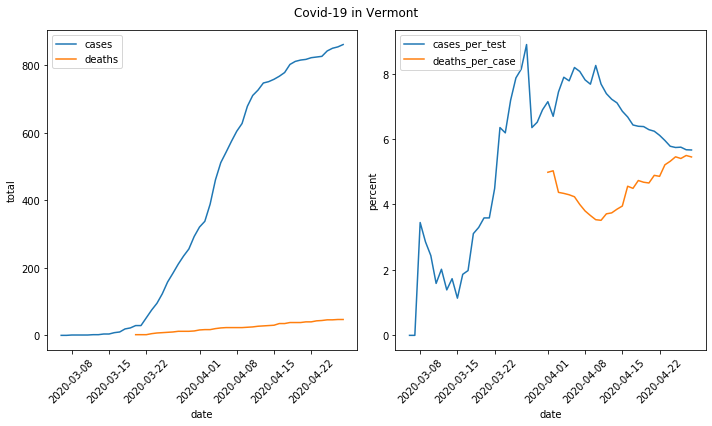

,date,entity,cases,deaths,tests,population,cases_per_million,cases_per_day,cases_per_day_7day_avg,cases_per_day_3day_avg,...,cases_per_test_per_day,cases_per_test_per_day_3day_avg,cases_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio,cases_per_test_per_day_3day_avg_14day_ratio,deaths_per_test,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio,deaths_per_test_per_day,deaths_per_test_per_day_3day_avg,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio,deaths_per_test_per_day_3day_avg_14day_ratio
2555,2020-04-23,Vermont,825.0,43.0,13852.0,623989,1322.138692,2.0,8.142857,3.000000,...,0.005128,0.011586,0.188181,0.209203,0.003104,0.005741,0.007692,0.007692,inf,inf
2554,2020-04-24,Vermont,827.0,44.0,14310.0,623989,1325.343876,2.0,6.857143,3.000000,...,0.004367,0.007913,0.079610,0.021550,0.003075,0.003336,0.002183,0.003292,3.679733,0.503661
2553,2020-04-25,Vermont,843.0,46.0,14682.0,623989,1350.985354,16.0,5.714286,6.666667,...,0.043011,0.017502,0.233375,0.048418,0.003133,0.004918,0.005376,0.005084,3.710656,0.741021
2552,2020-04-26,Vermont,851.0,46.0,14797.0,623989,1363.806093,8.0,5.571429,8.666667,...,0.069565,0.038981,0.461333,0.110466,0.003109,0.003175,0.000000,0.002520,1.317460,0.314819
2551,2020-04-27,Vermont,855.0,47.0,15073.0,623989,1370.216462,4.0,5.571429,9.333333,...,0.014493,0.042356,1.134955,1.288294,0.003118,0.003932,0.003623,0.003000,2.097641,1.426244
2550,2020-04-28,Vermont,862.0,47.0,15215.0,623989,1381.434609,7.0,6.285714,6.333333,...,0.049296,0.044451,1.153755,1.555888,0.003089,0.001876,0.000000,0.001208,0.622420,0.365923


In [35]:
# df = countries_df
# entity = 'New Zealand'
df = states_df
entity = 'Vermont'
df = df.loc[df['entity'] == entity, :]
fig, axes = plt.subplots(1, 2, figsize=(10,6))
# plot cases and deaths
ax = axes[0]
for var in ['cases', 'deaths']:
    ax.plot(df['date'], df[var], label=var)
    
ax.set_ylabel('total')
# plot rates
ax = axes[1]
for var in ['cases_per_test', 'deaths_per_case']:
    ax.plot(df['date'], df[var] * 100, label=var)

ax.set_ylabel('percent')

for i in range(2):
    ax = axes[i]
    ax.tick_params('x', labelrotation=45)
    #     plt.xticks(rotation=-45)
    ax.set_xlabel('date')
    ax.legend()

# ax.set_title(f'Covid-19 in {entity}')
fig.suptitle(f'Covid-19 in {entity}')
plt.tight_layout(rect=(0, 0, 1, .95))  
plt.show()
seven_days_ago = pd.to_datetime(datetime.date.today()) - datetime.timedelta(days=7)
df.loc[df['date'] > seven_days_ago] # pd.to_datetime('2020-04-15')]
       

## Trajectory Plots for deaths or deaths per million vs Date or Days Since

An excellent example of a similar plot of log(DPM) vs days since 0.1 DPM is https://ourworldindata.org/grapher/covid-deaths-days-since-per-million. It visually shows which countries are on similar trajectories, but makes it hard to compare the timeline of when interventions in countries are happening and what their outbreak looked like when those interventions were put in place.

Plotting log(DPM) vs date makes it harder to see the similarities of trajectories (though many of the trajectories look similar. Harder to plot those awesome sloped lines that say "doubles every 2 days", "doubles every 3 days", "doubles every 5 days", etc. Maybe an inset protractor-like graphic showing the doubling times.


### Hospital Beds

What is the medical capacity required to handle the peak of the infection. It depends on how full the beds are, at what rate new patients are coming in, and what rate old patients are leaving (death or recovery).

When plotted on a log(deaths per million) scale, what "slope" can a given amount of medical capacity (ICU beds, ventilators, healthcare workers, PPE, etc.) handle? Assume that the daily change in deaths per million is proportional (accounting for lag and growth changes) to incoming icu cases. For a steady state between incoming ICU cases and outgoing ICU cases (death and recovery), outgoing ICU cases (deaths and recoveries) must equal incoming ICU cases and therefore be proportional to delta deaths per million. And delta deaths per million relates deaths per million * slope. 

Why should we care? As deaths per million goes up, the slope must decrease to match hospital capacity. That means the government response must be stronger and more burdensome.
 
If delta_dpm exceeds this amount, than the number of incoming patients exceeds outgoing and must be absorbed by  available medical capacity. If delta_dpm is less than this amount, the number of incoming patients is less than the number of outgoing patients, and available hospital capacity increases.

In [28]:
# Seasonal Flu Death Source
# https://www.cdc.gov/flu/about/burden/index.html
# seasons: 2010-2011, 2011-2012, 2012-2013, 2013-2014, 2014-2015, 2015-2016, 2016-2017, 2017-2018
seasonal_flu_deaths = np.array([37000, 12000, 43000, 38000, 51000, 23000, 38000, 61000])
# US Population Source
# https://www.worldometers.info/world-population/us-population/
us_pop = 331000000 # estimated 2020 population
seasonal_flu_dpm = seasonal_flu_deaths.mean() / us_pop * 1e6
bad_flu_dpm = seasonal_flu_deaths.max() / us_pop * 1e6
print(f'seasonal_flu_dpm: {seasonal_flu_dpm:.0f}, bad_flu_dpm: {bad_flu_dpm:.0f}')


def plot_trajectories(df, index_col='date', values_col='deaths', rank=False, n_top=None,
                      ascending=False,
                      includes=None, excludes=None, n_show=None, log_yaxis=False,
                      show_legend=True,
                     ):
    '''
    df: columns: date, deaths, cases, population
    index_col: either date or days_since. This is the pivot index.
    values_col: e.g. deaths, deaths_per_million, deaths_per_day, deaths_per_million_per_day
    rank: plot the ranks of the values within each day.
    n_top: int > 0. Display the n highest trajectories on the chart.
    ascending: By default, "top_n" is sorted in descending order to show the worst off entities.
      For `rank=True` or to show entities that are hit least hard, sort in ascending order.
    n_show: int > 0. Show at most n on the chart.
    includes: array of entities to highlight.
    excludes: array of entities to exclude from chart.
    log_yaxis: if True, plot y-axis on a log scale.
    show_legend: add a legend to the plot. Sometimes the legend makes the plot less legible.
    '''
    log_yaxis = log_yaxis if log_yaxis is not None else (not rank and 'ratio' not in values_col)
    
    # https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
    if excludes:
        df = df.loc[~df['entity'].isin(excludes), :]
        
    # remove obsevations without values
    df = df.loc[df[values_col].notna(), :] 
    # remove observations without index value 
    # for example, days that happen before the first day of the days_since column
    df = df.loc[df[index_col].notna(), :]

    # Pivot to a table with country/entity columns and date/days_since rows
    piv = df.pivot(index=index_col, columns='entity', values=values_col)
    piv = piv.loc[piv.notnull().any(axis=1), :]  # remove rows with all null values

    # entities ranked by each day, or by each day since 0.1.
    if rank:
        piv = piv.rank(axis=1, method='average', ascending=False)
  
    # Plot countries in order, sorting by the most recent value for each entity.
    # For days_since, the last value can be nan. Find the most recent non-nan value.
    sort_idx = np.argsort(piv.apply(lambda s: s[s.notna()].iloc[-1], axis=0))
    if not (rank or ascending):
        # plot deaths per million from largest to smallest
        sort_idx = sort_idx[::-1]
        pass
    
    # Choose which entitites to plot
    sorted_entities = piv.columns.values[sort_idx]
#     print('Num sorted_entities:', len(sorted_entities))
    n_ent = len(sorted_entities) 
    n_top = n_ent if n_top is None else n_top
    n_show = n_ent if n_show is None else n_show
    includes_idx = np.isin(sorted_entities, includes) if includes else np.zeros_like(sorted_entities, dtype=bool)
    excludes_idx = np.isin(sorted_entities, excludes) if excludes else np.zeros_like(sorted_entities, dtype=bool)
    priority_idx = np.hstack([np.arange(n_ent)[includes_idx & ~excludes_idx],
                              np.arange(n_ent)[~includes_idx & ~excludes_idx]])
    show_entities = sorted_entities[np.sort(priority_idx[:n_show])]
    top_entities = sorted_entities[np.sort(priority_idx[:n_top])]
    print(len(show_entities), show_entities)
    # Figure
    fig, ax = plt.subplots(figsize=(16,8))
    for i, entity in enumerate(show_entities):
        if entity in top_entities:
            linewidth = 2.0
            alpha = 1.0
            entity_rank = np.arange(n_ent)[sorted_entities == entity][0] + 1
            label = f'{entity}[{entity_rank}]'
            annotation = entity
            last_idx = piv.index[piv[entity].notna()].values[-1]
        else:
            linewidth = 1.0
            alpha = 0.5
            label = None
            annotation = None
            
        if log_yaxis:
            plt.semilogy(piv.index, piv[entity], label=label, linewidth=linewidth, alpha=alpha,
                         marker='o', markersize='4')
        else: # if rank or 'ratio' in values_col or not log_yaxis:
            plt.plot(piv.index, piv[entity], label=label, linewidth=linewidth, alpha=alpha,
                     marker='o', markersize='4')

        if annotation:
            plt.annotate(entity, xy=(last_idx, piv[entity].loc[last_idx]))
            

    # pivot == 'days_since' maybe does not play well with bad_flu in the data.
    if values_col == 'deaths_per_million' and not rank:
        plt.axhline(seasonal_flu_dpm, color='blue', linestyle='--', label='seasonal flu')
        plt.axhline(bad_flu_dpm, color='orange', linestyle='--', label='bad flu')
        
    if values_col.endswith('_ratio'):
        plt.axhline(1, color='blue', linestyle='--', label='same')
        
    plt.grid(True, which='major')  # add gridlines (major and minor ticks)
    
    if rank:
        ax.invert_yaxis()
        
    ylabel = values_col
    if rank:
        ylabel += ' (rank)'
        
    if log_yaxis:
        ylabel += ' (log scale)'
        
    plt.ylabel(ylabel)
    
    if index_col == 'date':
        plt.xlabel('Date')
    elif index_col == 'days_since':
        plt.xlabel(f'Days since outbreak began')
      
    title = f'{values_col}{"" if not rank else " (rank)"} in Each Location' 
    title += ' Over Time' if index_col != 'days_since' else f' Since Outbreak Began'
    plt.title(title)
    
    plt.xticks(rotation=-60)
    if show_legend:
        plt.legend()
        
    plt.show()
    return piv




seasonal_flu_dpm: 114, bad_flu_dpm: 184


low population entities
['Alaska', 'Delaware', 'District of Columbia', 'North Dakota', 'South Dakota', 'Vermont', 'Wyoming']
43 ['Michigan' 'Connecticut' 'Minnesota' 'Oklahoma' 'New York' 'New Jersey'
 'Washington' 'Indiana' 'Massachusetts' 'Kentucky' 'Colorado' 'Maryland'
 'Ohio' 'Maine' 'Wisconsin' 'Nevada' 'Illinois' 'Missouri' 'Arizona'
 'Georgia' 'California' 'Pennsylvania' 'Oregon' 'Mississippi' 'New Mexico'
 'Alabama' 'North Carolina' 'Virginia' 'Kansas' 'Florida' 'West Virginia'
 'Montana' 'South Carolina' 'New Hampshire' 'Idaho' 'Rhode Island' 'Texas'
 'Hawaii' 'Iowa' 'Tennessee' 'Arkansas' 'Nebraska' 'Utah']


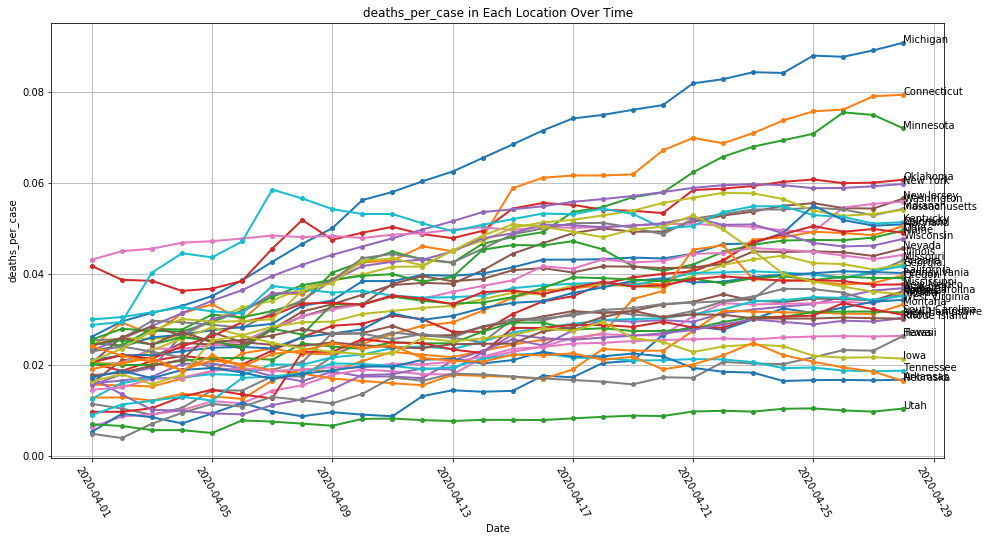

In [29]:
# lockdowns:
# Minnesota - stay-at-home 3/27 https://www.mprnews.org/story/2020/03/25/latest-on-covid19-in-minnesota
# New Zealand - lockdown 3/25 https://www.washingtonpost.com/world/asia_pacific/new-zealand-isnt-just-flattening-the-curve-its-squashing-it/2020/04/07/6cab3a4a-7822-11ea-a311-adb1344719a9_story.html

df = states_df
# df = countries_df
# df = all_df

us_states = list(states_df['entity'].unique())
includes = list(set([
#     'United States',
#     'Japan', 
#     'Singapore', 
#     'South Korea',
#     'Italy', 
#     'Spain', 
#     'France',
    'Vermont', 
    'California',
#     'Washington', 
    'New York', 
    'Michigan', 'Louisiana', 
    'Massachusetts',
#     'Rhode Island',
#             'China',
    'New Zealand',
#     'New York',
#     'EU',
#     countries from https://www.washingtonpost.com/opinions/2020/04/08/is-swedens-lax-approach-coronavirus-backfiring/
    'Sweden',
#     'Denmark', 'Norway', 'Malta', 'United Kingdom', 'Italy',
# States ~3-5M in population
# 'Arkansas', 'Nevada', 'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma', 'Oregon',
#              'Kentucky', 'Louisiana', 'Alabama',
    
]
# + us_states
# + eu_countries
))
low_pop_entities = list(df.loc[df['population'] < 1e6, 'entity'].unique())
print(f'low population entities\n{low_pop_entities}')
excludes = list(set([
# Excludes low-population entities with high deaths-per-capita.
'World',
'Puerto Rico',
    'Louisiana'
] 
    + low_pop_entities
))

# index_col = 'days_since'
index_col = 'date'
log_yaxis = False

# values_col = 'deaths_per_million'; log_yaxis = True
# values_col = 'deaths_per_million_per_day_7day_avg'; log_yaxis = False
# values_col = 'deaths_per_million_per_day_3day_avg'; log_yaxis = False
# values_col = 'deaths'
# values_col = 'deaths_per_day'
# values_col = 'deaths_ratio_per_day_7day_avg'
# values_col = 'deaths_per_day_7day_avg'
values_col = 'deaths_per_case'; log_yaxis = False
# values_col = 'deaths_per_case_per_day_7day_avg'; log_yaxis = False
# values_col = 'cases_per_million'; log_yaxis = False
# values_col = 'cases_per_million_per_day_7day_avg'; log_yaxis = False
# values_col = 'cases_per_million_per_day_3day_avg'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg'
# values_col = 'cases'
# values_col = 'cases_per_test'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg_14day_ratio'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio'; log_yaxis = False
# values_col = 'cases_per_test_per_day_3day_avg_14day_ratio'; log_yaxis = False
# values_col = 'deaths_per_test'; log_yaxis = False
# values_col = 'deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio'; log_yaxis = False
# values_col = 'deaths_per_test_per_day_3day_avg_14day_ratio'; log_yaxis = False

# FT threshold condition https://www.ft.com/coronavirus-latest 2020-03-02
# days_since_col = 'deaths_per_day'; days_since_thresh = 3.0
# FT thesh: number of days since 30 daily cases first recorded
# days_since_col = 'cases_per_day'; days_since_thresh = 30
# OWID threshold condition https://ourworldindata.org/grapher/covid-deaths-days-since-per-million
# days_since_col = 'deaths_per_million'; days_since_thresh = 0.1
# Other thresholds
# days_since_col = 'cases_per_million'; days_since_thresh = 1
# days_since_col = 'deaths'; days_since_thresh = 1
# days_since_col = 'cases'; days_since_thresh = 1
# days_since_col = 'deaths_per_day'; days_since_thresh = 1.0
# Good for 14day deaths/test ratio and cases/test ratio b/c earlier the ratio is huge.
# days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-15')
days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-01')

# Trim rows before the timeperiod we are looking at:
if days_since_col:
    df[values_col] = fill_before_first(df, values_col, days_since_thresh, thresh_col=days_since_col)
    if index_col == 'days_since':
        df['days_since'] = make_days_since(df, days_since_col, days_since_thresh)

n_top = 52
# n_top = len(includes)
n_show = n_top
rank = False
# rank = True
ascending = False
# ascending = True  # for cases/test 14day ratio, lower is better


piv = plot_trajectories(df, index_col=index_col, values_col=values_col, 
                        rank=rank, n_top=n_top, n_show=n_show,
                        includes=includes, excludes=excludes,
                        log_yaxis=log_yaxis,
                        ascending=ascending,
                        show_legend=False
                       )


## Erickson Analysis of Death Rate

In [ ]:
df = states_df
# erickson briefing: https://www.youtube.com/watch?v=xfLVxx_lBLU
# erickson population infection rate estimated from cases-per-test
# erickson population cases estimated as infection rate * population
# erickson population chance of death is deaths per population case 
# herd chance of death says, what if the population prevalence is 60% and the death rate remains the same.
#   then herd chance of death is: deaths / (pop prevalence)  deaths per population case

# confirmed cases is a vast underestimate of true cases, since many/most cases are not tested.
#   antibody studies place the population cases at ~16x to 55x (or more) the confirmed cases.
# erickson estimates the true cases using cases-per-test * population. Based on the antibody
#   studies coming out, this seems like an overestimate of the true cases, by ~1-7x?

df['cases_per_capita'] = df['cases'] / df['population']
df['erickson_cases'] = (df['cases_per_test'] * df['population']).round()
df['erickson_cases_per_capita'] = df['cases_per_test']
df['erickson_deaths_per_case'] = df['deaths'] / df['erickson_cases']
df['erickson_cases_per_confirmed_case'] = df['erickson_cases'] / df['cases']
df['herd_cases'] = df['population'] * 0.6
df['herd_dpm'] = df['deaths_per_case'] * 1e6 * 0.6
df['herd_erickson_dpm'] = df['erickson_deaths_per_case'] * 1e6 * 0.6
# df['herd_deaths']
# df['herd_chance_of_death'] = df['erickson_chance_of_death'] * (0.6 / df['cases_per_test']) 
df['erickson_cases'] = df['erickson_cases'].apply(lambda x: x if pd.isnull(x) else int(x))

In [ ]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'deaths', 
     'tests', 
     'cases',
     'population', 
 ]]
 .groupby('entity').last()
)


In [ ]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'deaths_per_case',
 ]]
 .groupby('entity').last()
)


In [ ]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'cases_per_test',
     'erickson_cases',
     'erickson_deaths_per_case',
 ]]
 .groupby('entity').last()
)


In [ ]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'erickson_cases_per_confirmed_case',
 ]]
 .groupby('entity').last()
)


In [ ]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'herd_dpm',
     'herd_erickson_dpm',
 ]]
 .groupby('entity').last().sort_values(by='herd_erickson_dpm')
)

In [ ]:
df['nys_multiple'] = (0.144 * df['population']) / df['cases']
df.loc[df['entity'] == 'New York', :].tail()

Feedback on my email.

> Thanks Todd this is great! Very accessible writing. 

> Can you add an analysis and conclusion for the old and sick?

> Also re: your conclusion for society (and other "open it up!" advocates)...
> 
> - About 1/3 of Americans are 60 or older
> - About the same percentage of adults have hypertension 
> - 10.5% are diabetic
> - 40% of adults are obese

> These are not additive, of course, but we are talking about simultaneously isolating and protecting between 1/3 and greater than 50% of people, while everyone else gets a disease. That is a fantasy. If we are getting to 60% antibodies, a lot of people over 60 and with comorbidities are getting it too. 

> Also, the current economic damage is not being done by a hard lockdown. Most places have a soft lockdown or less (many categories of stores open, huge categories of workers considered essential, freedom to travel and use public streets and, in most cases, open parks).  There is guidance to stay at home and many people are choosing to limit travel and activity because they have a legitimate fear for someone over 60 or with comorbidities. So, what reduction in activity is reasonable for a disease with a death rate for those over 60 and with comorbidities of, say 1%-5%? Closed stadiums, concert venues and movie theaters? Limited international travel? Increased spacing in bars and restaurants? Avoiding amusement parks and cruises? Pretty quickly it adds up to, what, 10% of the economy? 20%? Shutting that fraction of the economy for months and months is devastating and inevitable if it the disease is at epidemic levels.

## New York City: Age and Comorbidities

Explore how the case fatality rate differs for younger cohorts vs the entire population of cases. Explore how many of the people dying have comorbidities.

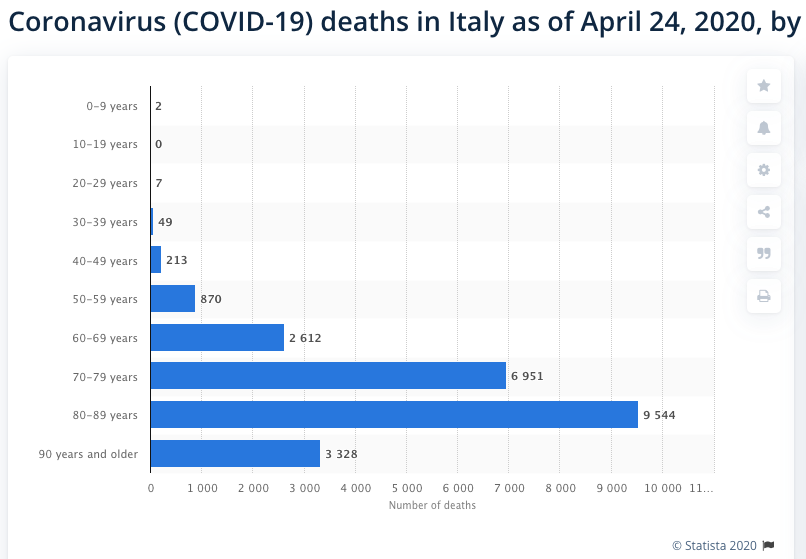

In [ ]:
deaths_df, df = load_nyc_age_comorbidity_death_data()
print(deaths_df.pivot(index='age_band', columns='comorbidity'))
# print(df)
deaths_df.groupby('age_band').sum()['deaths']

# nyc deaths-per-case
print('NYC deaths_per_case')
print(df['deaths'].sum() / df['cases'].sum())
# nyc deaths-per-case under 65
print('NYC deaths_per_case under 65')
u65 = df.loc[df['age_band'].isin(['0-17', '18-44', '45-64'])]
u65_deaths_per_case = u65['deaths'].sum() / u65['cases'].sum()
print(u65_deaths_per_case)
# nyc deaths-per-case under 45
print('NYC deaths_per_case under 45')
u45 = df.loc[df['age_band'].isin(['0-17', '18-44'])]
u45_deaths_per_case = u45['deaths'].sum() / u45['cases'].sum()
print(u45_deaths_per_case)
# among people who are dying, what fraction of them have comorbidities?
comorb = deaths_df.groupby('comorbidity').sum()
print('Percent of NYC deaths with comorbidity')
high_comorb_pct = (comorb.loc['yes', 'deaths'] + comorb.loc['unknown', 'deaths']) / comorb['deaths'].sum()
low_comorb_pct = comorb.loc['yes', 'deaths'] / comorb['deaths'].sum()
no_unk_comorb_pct = comorb.loc['yes', 'deaths'] / (comorb.loc['yes', 'deaths'] + comorb.loc['no', 'deaths'])
print(low_comorb_pct, no_unk_comorb_pct, high_comorb_pct)
